In [38]:
import sys
if True: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/omega/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/omega/")
else: # Local
    root = './'

Mounted at /content/drive


In [39]:
!pip3 install cmocean
!pip3 install git+https://github.com/rtqichen/torchdiffeq
!pip3 install git+https://github.com/afqueiruga/detest

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-rcu3kzmd
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-rcu3kzmd
  Created wheel for torchdiffeq: filename=torchdiffeq-0.0.1-cp36-none-any.whl size=25885 sha256=64157a4904306cc51cccb80080ad1f8ec740baba61bd56f5b2621b01d1e1de6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-g6lz9bxe/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq
  Cloning https://github.com/afqueiruga/detest to /tmp/pip-req-build-ynncv8gm
  Running command git clone -q https://github.com/afqueiruga/detest /tmp/pip-req-build-ynncv8gm
  Created wheel for detest: filename=detest-0.2-cp36-none-any.whl size=25777 sha256=41d05bd7622db0f22d9ce9b741b6927b019041ff85ce4c6973fd33990f27c56b
  Stored in directory: /tmp/pip-ephem-wheel-cache-iangfwlv/wheels/cf/eb/8d/b43ec04f6a026a547606a4875bd0c6d47526603afc70545b86
Successfully built detest


In [0]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
#print(plt.style.available)

In [0]:
import torchdiffeq

In [0]:
import utils
import plotting
import helper
import models
import ode_helper
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)

from helper import *
from utils import *
from analytical_solutions import *

In [43]:
device = get_device()
set_seed()

Connected to a GPU


In [44]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


# Learning the pendulum in theta-space

Firstly, we make a dataset of the pendulum trajectory. The solution to the nonlinear pendulum is
\begin{equation}
\theta(t)=2\arcsin\left( \sin\frac{\theta_0}{2} \mathrm{sn}\left(K\left(\sin^2\frac{\theta_0}{2}\right)-\omega_0t \, ; \, \sin^2\frac{\theta_0}{2} \right)\right)
\end{equation}
where $K$ is the complete elliptic integral of the first kind, and $\mathrm{sn}$ is the Jacobi elliptic function of the first kind. The key identity to obtaining the rate of $\theta$ is $sn'(x)=x'cn(x)dn(x)$.
The angular frequency $\omega_0$ is 
\begin{equation}
\omega_0 = \sqrt{g/R}
\end{equation}

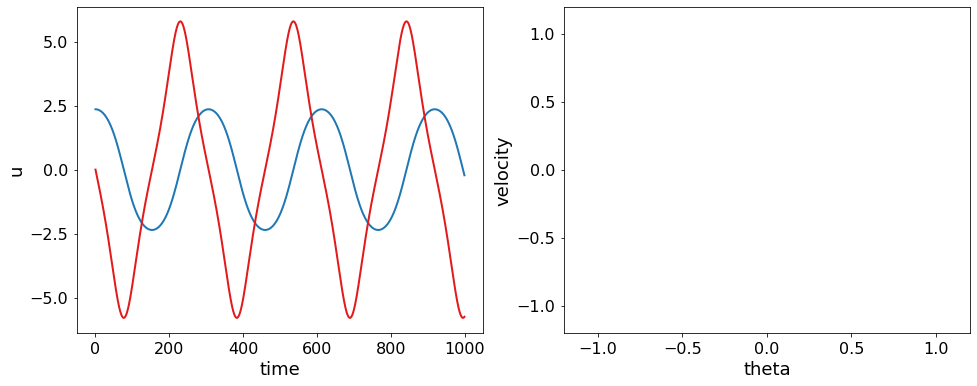

In [118]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_theta(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])
theta_ts = data_to_torch(anal_ts,device)#.reshape(-1,1)
theta_data = data_to_torch(data,device)#.reshape(-1,1,data.shape[-1])

In [0]:
## TODO: Migrate out
def solve_and_plot(model, model_ts, data, data_ts=None, method='rk4', idcs=0):
    if data_ts is None:
        data_ts = model_ts
    with torch.no_grad():
        pred = torchdiffeq.odeint(model, data[0,:], model_ts, method=method)
    plt.plot(data_ts.cpu().numpy(), data.detach().cpu().numpy()[:,idcs], '--')
    plt.plot(model_ts.cpu().numpy(), pred.detach().cpu().numpy()[:,idcs],'x-')

In [0]:
ts_double = torch.linspace(0,t_max,N_time_step//10)
ts_half = torch.linspace(0,t_max,N_time_step*10)
def plot_3x3(model, data, data_ts, idcs=slice(0,2)):
    plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*2))
    plots = [('euler','Euler (trained on)'),
             ('midpoint','Midpoint (inference)'),
             ('rk4','RK4 (inference)')]
    ts_sets = [(ts_half,'Half $\Delta t$'), (data_ts,'Trained $\Delta t$'), (ts_double, 'Twice $\Delta t')]
    for j,(tset,tlabel) in enumerate(ts_sets):
        for i,(method,title) in enumerate(plots):
            plt.subplot(3,3,1+3*j+i)
            plt.title(title)
            solve_and_plot(model,tset, data,data_ts,method,idcs=idcs)
            if(i==0): plt.ylabel(tlabel+'\n x(t),y(t)')
            if(j==3-1): plt.xlabel('t')
    plt.tight_layout()

Parameterized by the $\theta$, the pendulum obeys the law
\begin{equation}
\ddot{\theta} = g \sin(\theta)
\end{equation}
with a dummy variable $v=\dot{\theta}$. Below is an implementation of this rate:

In [0]:
class PendulumForceTheta(torch.nn.Module):
    def __init__(self):
        super(PendulumForceTheta,self).__init__()
    def forward(self,t, State):
        theta, v = State[:,0], State[:,1]
        g = -9.81
        return torch.stack([
            v,
            g*torch.sin(theta),
        ],dim=-1)
FTrue = PendulumForceTheta()

As a sanity check, we use this hand-coded "model" to solve with the known ode solvers to see the expected behavior. The explicit midpoint and RK4 do just fine on this method, but forward euler falls off of the attracter and starts to diverge.

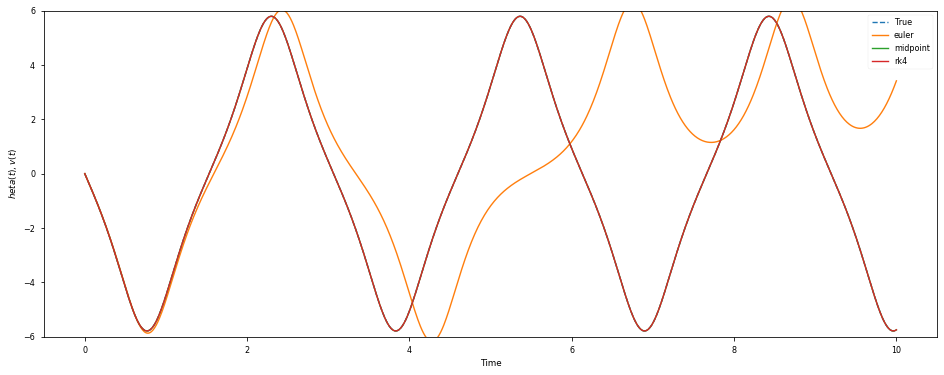

In [146]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.plot(theta_ts.cpu().numpy(),theta_data.cpu().numpy()[:,1],'--',label='True')
with torch.no_grad():
    for m in ['euler','midpoint','rk4']:#,'dopri5']:
        pred = torchdiffeq.odeint(FTrue, theta_data[0:1,:], theta_ts, method=m)
        plt.plot(theta_ts.cpu().numpy(),pred.detach().cpu().numpy().reshape(-1,2)[:,1],label=m)
plt.legend()
plt.ylim(-6,6)
plt.ylabel("$\theta(t), v(t)$")
plt.xlabel("Time")
plt.savefig('plots/pend_theta_traditional_odesolver.png')
plt.show()

## These are the representative models

These four models all have the same amount of parameters and the same architecture. The skip RNN has a skip-connection (AKA ResNet), and the two odes also take in an unused time variable because they will be plugged into an ode solver.

In [0]:
rnn = models.ShallowNet(2,2,50).double().to(device)
skiprnn = models.ShallowSkipNet(2,50).double().to(device)
ode_neural = models.ShallowODE(2,50).double().to(device)
ode_multi = models.ShallowODE(2,50).double().to(device)

In [0]:
ode_multi_mr = models.ShallowODE(2,50).double().to(device)

First, we try the NN types

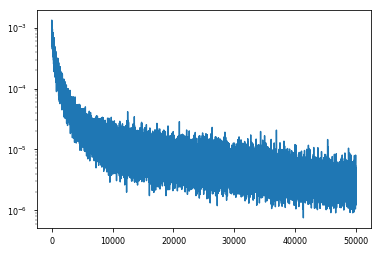

In [0]:
_,losses=learn_rnn(theta_data, rnn, device=device, N_iter=50000)
plt.semilogy(losses)

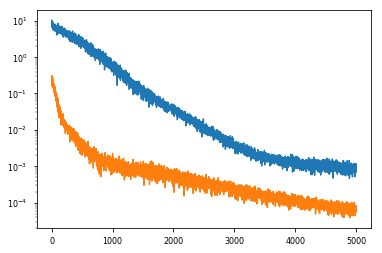

In [0]:
_,losses = learn_rnn(theta_data, rnn, device=device, N_iter=50000)
plt.semilogy(losses)
_,losses = learn_rnn(theta_data, skiprnn, device=device, N_iter=50000)
plt.semilogy(losses)

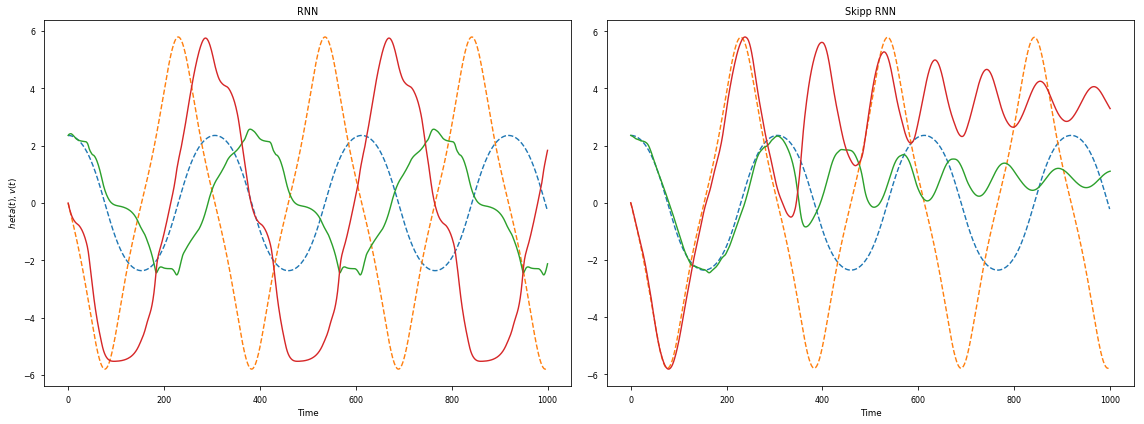

In [0]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
y0 = theta_data[0:1,:]#data_to_torch([2.5,0],device=device)
ys_rnn = integrate_model(rnn,y0, 1000)
ys_resrnn = integrate_model(skiprnn,y0, 1000)
def plotem(ys,i):
    plt.subplot(1,2,i)
    plt.plot(data,'--')
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
    plt.xlabel('Time')
plotem(ys_rnn,1)
plt.title('RNN')
plt.ylabel(' $\theta(t) , v(t)$')
plotem(ys_resrnn,2)
plt.title('Skipp RNN')
plt.tight_layout()
plt.savefig('plots/pend_theta_nets.png')

In [0]:
rnn_2 = models.ShallowNet(2,2,2,Act=torch.nn.Tanh).double().to(device)

In [0]:
y0 = theta_data[0:1,:]
ys_rnn_2 = integrate_model(rnn_2,y0, 1000)

Text(0.5, 0, 'Time')

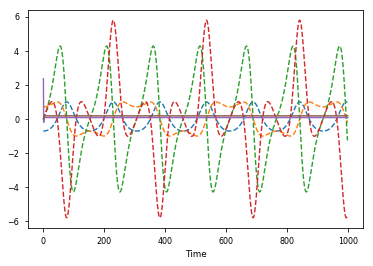

In [0]:
plt.plot(data,'--')
plt.plot(ys_rnn_2[:,0])
plt.plot(ys_rnn_2[:,1])
plt.xlabel('Time')

Next, we try the neural ODE, which learns a nonlinear function embedded inside of an ode solver.

Connected to a GPU


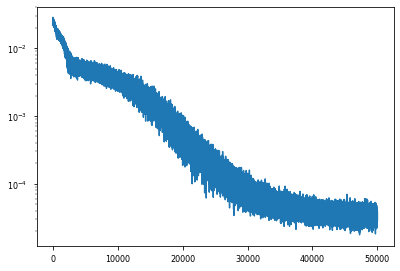

In [21]:
_,losses = ode_helper.train_a_neural_ode(theta_data, theta_ts, ode_neural)
plt.semilogy(losses)

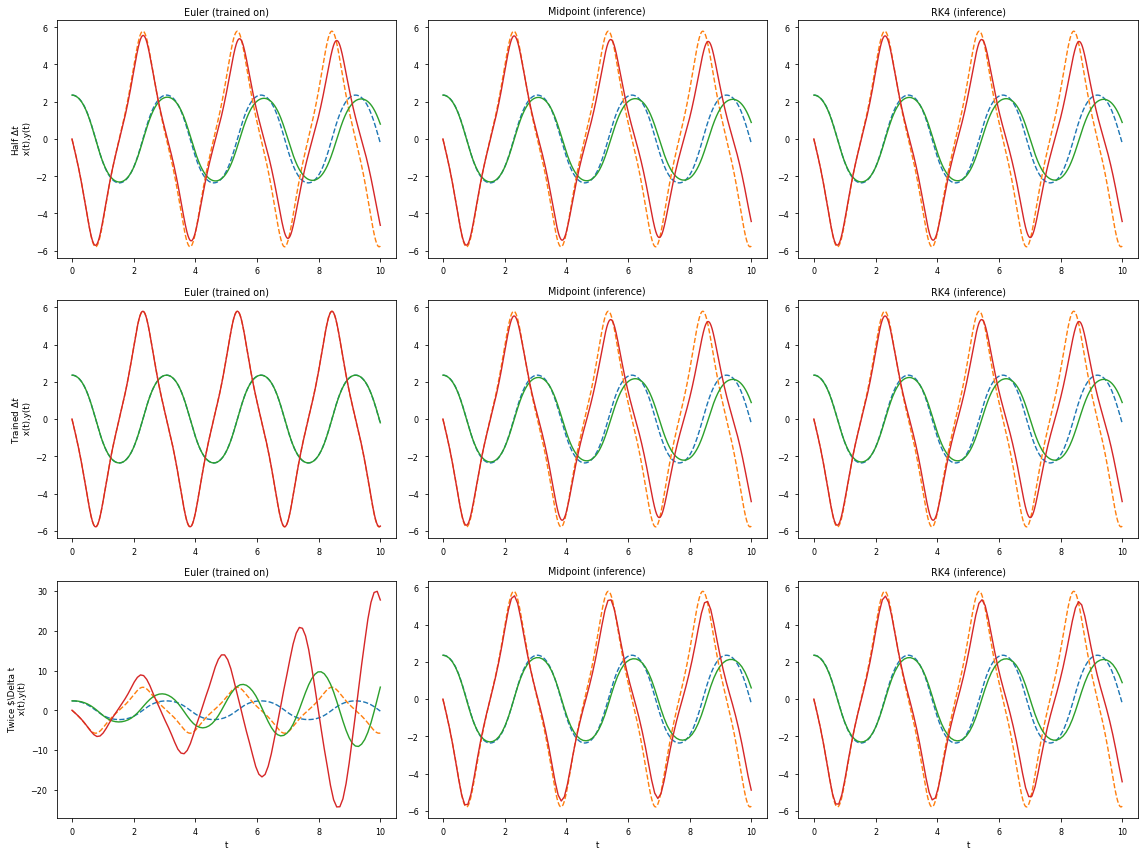

In [50]:
plot_3x3(ode_neural, theta_data, theta_ts)
plt.savefig('plots/pend_theta_ode.png')

Connected to a GPU


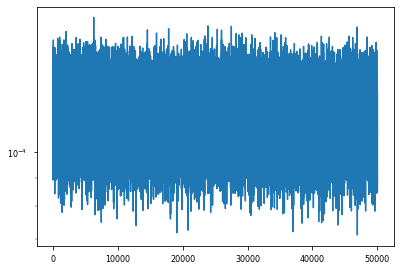

In [158]:
_,losses = ode_helper.train_a_neural_ode_multi_method(theta_data, theta_ts, ode_multi)
plt.semilogy(losses)

Connected to a GPU


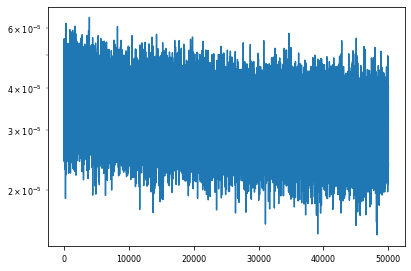

In [159]:
_,losses = ode_helper.train_a_neural_ode_multi_method(theta_data, theta_ts, ode_multi_mr,
                                                      methods=('midpoint','rk4'))
plt.semilogy(losses)

In [0]:
def get_error(model, h_scale,N_time_step,method='euler'):
    quick_factor = 20.0
    nt = int(N_time_step/quick_factor/h_scale)
    anal_ts = np.linspace(0,t_max/quick_factor, nt)
    anal = solution_pendulum_theta(anal_ts, 1.5*np.pi/2)
    with torch.no_grad():
        pred = torchdiffeq.odeint(model, torch.tensor(anal[0,:],device=device).unsqueeze(0),
                                  torch.tensor(anal_ts,device=device), method=method)
    return np.linalg.norm(pred.cpu().numpy()[:,0,:]-anal)/nt

In [0]:
hs = [0.01,0.025,0.05,0.1,0.2,0.25,0.5,0.6,0.9,1.0,1.1,1.5,2.0,5.0,7.5,10.0,12,15,20]
def do_error_runs(model):
    errs = {}
    for method in ['euler','midpoint','rk4']:
        errs[method] = [ get_error(model,h,N_time_step,method=method) for h in hs]
    return errs

In [0]:
err_neural = do_error_runs(ode_neural)
err_multi = do_error_runs(ode_multi)
err_multi_mr = do_error_runs(ode_multi_mr)

In [156]:
err_true = do_error_runs(FTrue)

torch.Size([5000, 1, 2]) (5000, 2)
torch.Size([2000, 1, 2]) (2000, 2)
torch.Size([1000, 1, 2]) (1000, 2)
torch.Size([500, 1, 2]) (500, 2)
torch.Size([250, 1, 2]) (250, 2)
torch.Size([200, 1, 2]) (200, 2)
torch.Size([100, 1, 2]) (100, 2)
torch.Size([83, 1, 2]) (83, 2)
torch.Size([55, 1, 2]) (55, 2)
torch.Size([50, 1, 2]) (50, 2)
torch.Size([45, 1, 2]) (45, 2)
torch.Size([33, 1, 2]) (33, 2)
torch.Size([25, 1, 2]) (25, 2)
torch.Size([10, 1, 2]) (10, 2)
torch.Size([6, 1, 2]) (6, 2)
torch.Size([5, 1, 2]) (5, 2)
torch.Size([4, 1, 2]) (4, 2)
torch.Size([3, 1, 2]) (3, 2)
torch.Size([2, 1, 2]) (2, 2)
torch.Size([5000, 1, 2]) (5000, 2)
torch.Size([2000, 1, 2]) (2000, 2)
torch.Size([1000, 1, 2]) (1000, 2)
torch.Size([500, 1, 2]) (500, 2)
torch.Size([250, 1, 2]) (250, 2)
torch.Size([200, 1, 2]) (200, 2)
torch.Size([100, 1, 2]) (100, 2)
torch.Size([83, 1, 2]) (83, 2)
torch.Size([55, 1, 2]) (55, 2)
torch.Size([50, 1, 2]) (50, 2)
torch.Size([45, 1, 2]) (45, 2)
torch.Size([33, 1, 2]) (33, 2)
torch.Siz

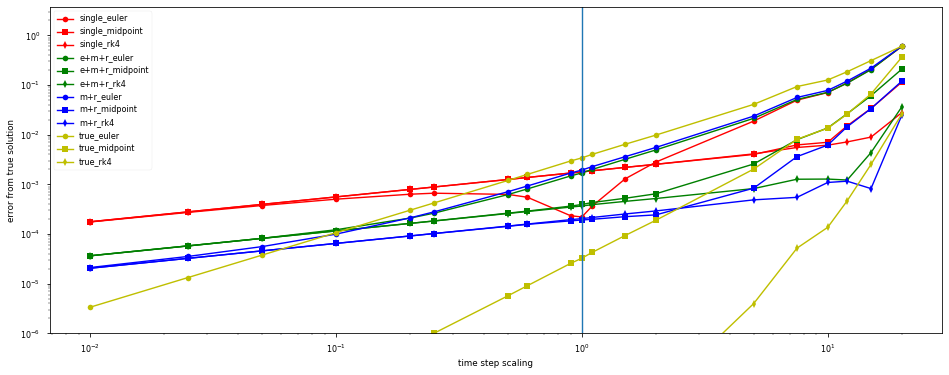

In [165]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
colorwheel = cycle('rgby')
markerwheel = cycle('osd')
colordict = defaultdict(lambda : next(colorwheel))
markerdict = defaultdict(lambda:next(markerwheel))
for name,errset in zip(['single','e+m+r','m+r','true'],
                       [err_neural,err_multi,err_multi_mr,err_true]):
    for k,err in errset.items():
        plt.loglog(hs,err,label=name+'_'+k,color=colordict[name],marker=markerdict[k])
plt.axvline(1.0)
plt.ylabel('error from true solution')
plt.xlabel('time step scaling')
plt.ylim(bottom=10**-6)
plt.legend()
plt.show()

Finally, we show our approach, which uses multiple ODE solvers to force it not overfit.

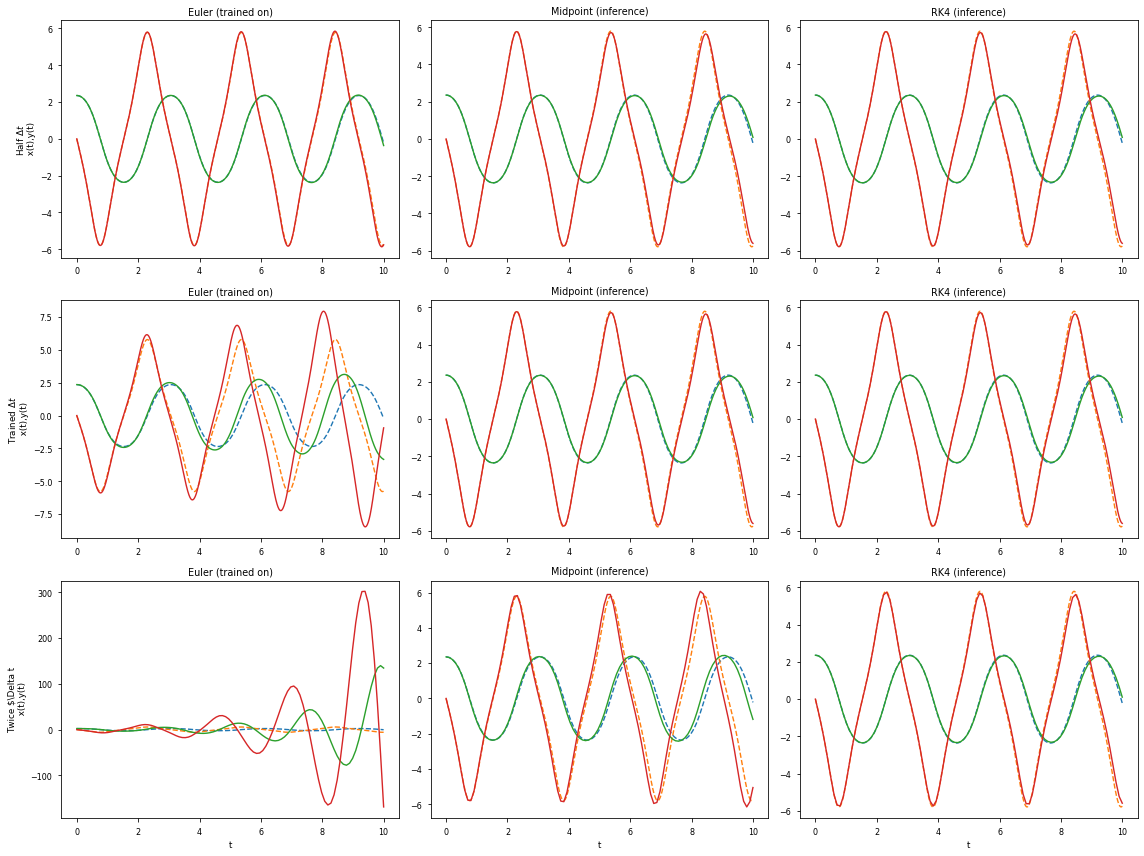

In [116]:
plot_3x3(ode_multi, theta_data, theta_ts)
plt.savefig('plots/pend_theta_multi.png')

# Learning the pendulum in xy space

Now, we sovle the same exact problem as above, but in a cartesian space. This makes the problem "more nonlinear", and adds a constraint to it. There are now four degrees of freedom, as opposed to two.

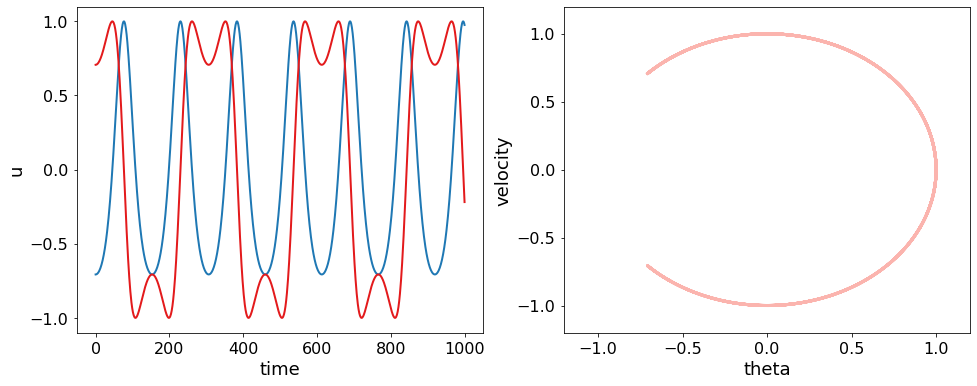

In [115]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
tmpxy_anal_ts = np.linspace(0,t_max,N_time_step)
tmpxy_data = solution_pendulum_xy(tmpxy_anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([tmpxy_data])
xy_ts = data_to_torch(tmpxy_anal_ts,device)#.reshape(-1,1)
xy_data = data_to_torch(tmpxy_data,device)#.reshape(-1,1,data.shape[-1])

## Solve it with an known ODE formula

We have older and trusted libraries for integrating odes, but using torchdiffeq just holds all things equal. The constraint force $f$ is derived from the formula $v\cdot n = 0$ which implies $\dot{\overline{v\cdot n}}=a\cdot n + v\cdot v=0$, yielding,
\begin{equation}
f = v\cdot v + g\cdot n
\end{equation}
Because of the constraint, this becomes a stiff equation.

In [0]:
class PendulumForceXY(torch.nn.Module):
    def __init__(self):
        super(PendulumForceXY,self).__init__()
    def forward(self,t, State):
        x,y,vx,vy = State[:,0], State[:,1], State[:,2], State[:,3]
        nx, ny = -x, -y
        gx, gy = -9.81, 0
        f = (vx*vx + vy*vy) + (gx*nx + gy*ny)
        return torch.stack([
            vx,
            vy,
            f*nx-gx,
            f*ny-gy,
        ],dim=-1)
FTrueXY = PendulumForceXY()

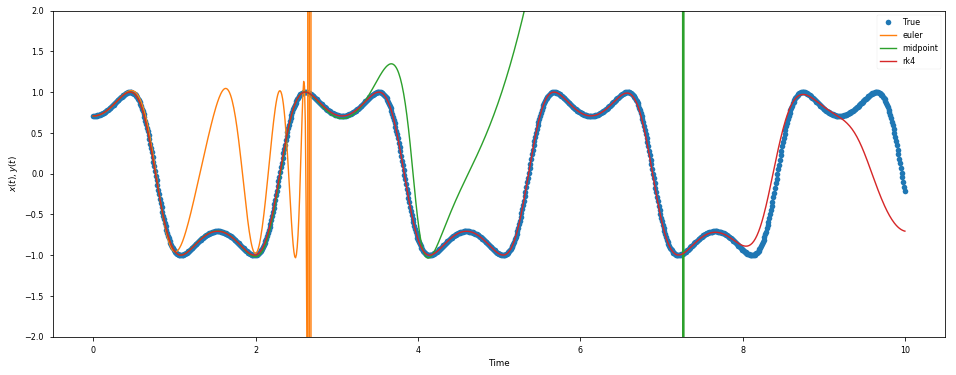

In [0]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.plot(anal_ts,data[:,1],'o',label='True')
with torch.no_grad():
    for m in ['euler','midpoint','rk4']:#,'dopri5']:
        pred = torchdiffeq.odeint(FTrueXY, xy_data[0:1,:], xy_ts, method=m)
        plt.plot(xy_ts.cpu().numpy(),pred.detach().cpu().numpy().reshape(-1,4)[:,1],label=m)
plt.legend()
plt.ylim(-2,2)
plt.ylabel("$x(t), y(t)$")
plt.xlabel("Time")
plt.savefig('plots/pend_xy_traditional_odesolver.png')
plt.show()

Note how the traditional ODE solvers don't do a very good job with this stiff formulation. This is well understood, even though we had hoped for a little better.

## Learn a discrete RNN

Using the CPU


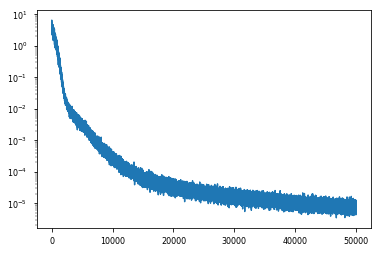

In [0]:
model_rnn = models.ShallowNet(4,4,hidden=50).double()
_,losses = learn_rnn(torch_data, model_rnn, N_iter=50000)
plt.semilogy(losses)

Using the CPU


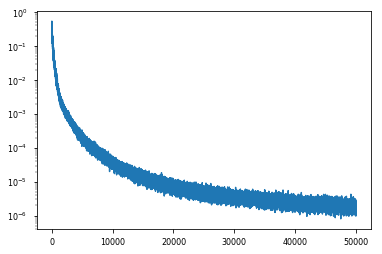

In [0]:
model_resrnn = models.ShallowSkipNet(4,hidden=50).double()
_,losses = learn_rnn(torch_data, model_resrnn, N_iter=50000)
plt.semilogy(losses)

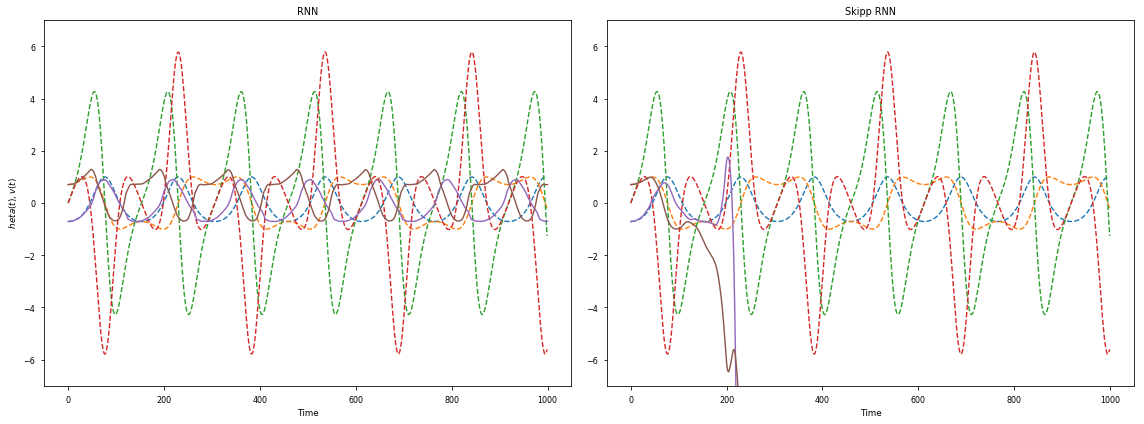

In [0]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
y0 = xy_data[0:1,:]#data_to_torch([2.5,0],device=device)
ys_rnn = integrate_model(model_rnn,y0, 1000)
ys_resrnn = integrate_model(model_resrnn,y0, 1000)
def plotem(ys,i):
    plt.subplot(1,2,i)
    plt.plot(xy_data.cpu().numpy(),'--')
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
    plt.xlabel('Time')
plotem(ys_rnn,1)
plt.title('RNN')
plt.ylabel(' $\theta(t) , v(t)$')
plt.ylim(-7,7)
plotem(ys_resrnn,2)
plt.title('Skipp RNN')
plt.ylim(-7,7)
plt.tight_layout()
plt.savefig('plots/pend_theta_nets.png')

#= deprecated
y0 = data_to_torch([1,0,0,0],device=device)
ys_rnn = integrate_model(model_rnn,y0, 100)
ys_resrnn = integrate_model(model_resrnn,y0, 100)
def plotem(ys):
    plt.subplot(1,2,1)
    plt.plot(ys[:,0])
    plt.plot(ys[:,1])
    plt.subplot(1,2,2)
    plt.plot(ys[:,2])
    plt.plot(ys[:,3])
plotem(ys_rnn)
plt.figure()
plotem(ys_resrnn)

## Learn a Neural ODE

In [0]:
model_neuralode=models.ShallowODE(4, hidden=50).double().to(device)

In [0]:
model_neuralode,losses = train_a_neural_ode(torch_data,torch_ts, model=model_neuralode, device=device, batch_size=25, method='euler')

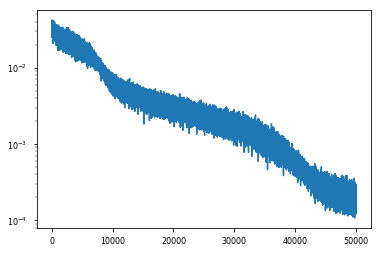

In [0]:
plt.semilogy(losses)

ts_double = torch.linspace(0,t_max,N_time_step//2)
ts_half = torch.linspace(0,t_max,N_time_step*2)
def plot_3x3(model, idcs=slice(0,2)):
    plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*3))
    plots = [('euler','Euler (trained on)'),
             ('midpoint','Midpoint (inference)'),
             ('rk4','RK4 (inference)')]
    ts_sets = [(ts_half,'Half $\Delta t$'), (torch_ts,'Trained $\Delta t$'), (ts_double, 'Twice $\Delta t')]
    for j,(tset,tlabel) in enumerate(ts_sets):
        for i,(method,title) in enumerate(plots):
            plt.subplot(3,3,1+3*j+i)
            plt.title(title)
            solve_and_plot(model,tset, torch_data,torch_ts,method,idcs=idcs)
            if(i==0): plt.ylabel(tlabel+'\n x(t),y(t)')
            if(j==3-1): plt.xlabel('t')
    plt.tight_layout()

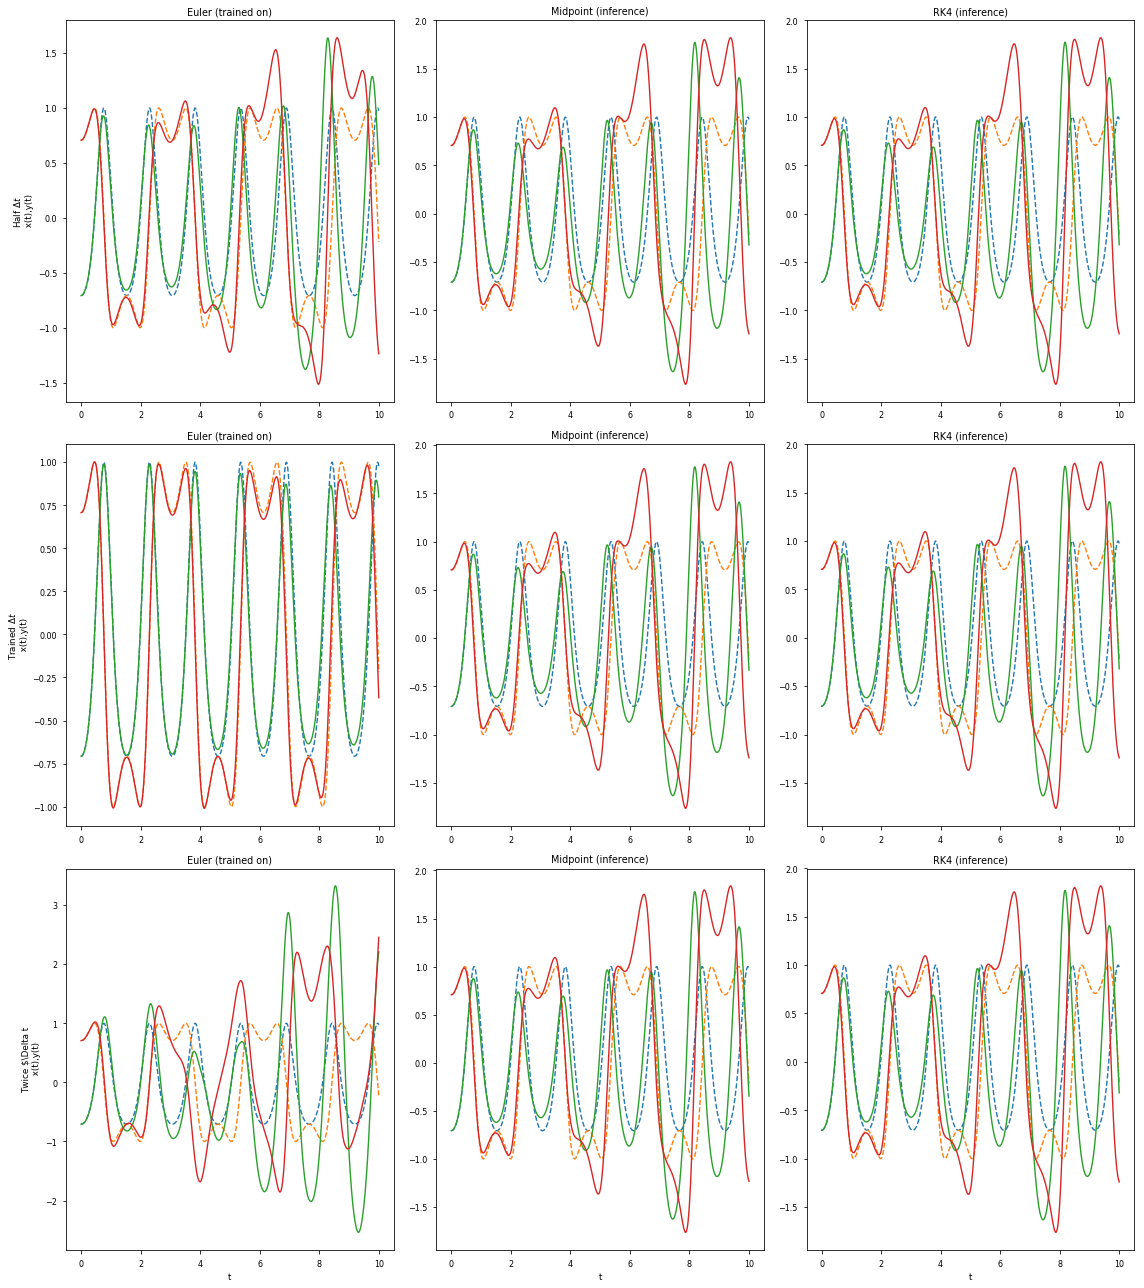

In [0]:
plot_3x3(model_neuralode, xy_data, xy_ts)
plt.savefig('plots/pend_xy_ode.png')

## Correctly learn the dynamics

In [0]:
model_multi=models.ShallowODE(4, hidden=50).double()

In [0]:
model_multi,losses = train_a_neural_ode_multi_method(torch_data,torch_ts, model=model_multi, device=device, batch_size=25)

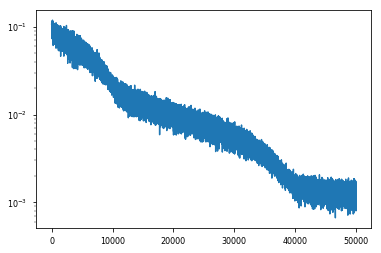

In [0]:
plt.semilogy(losses)

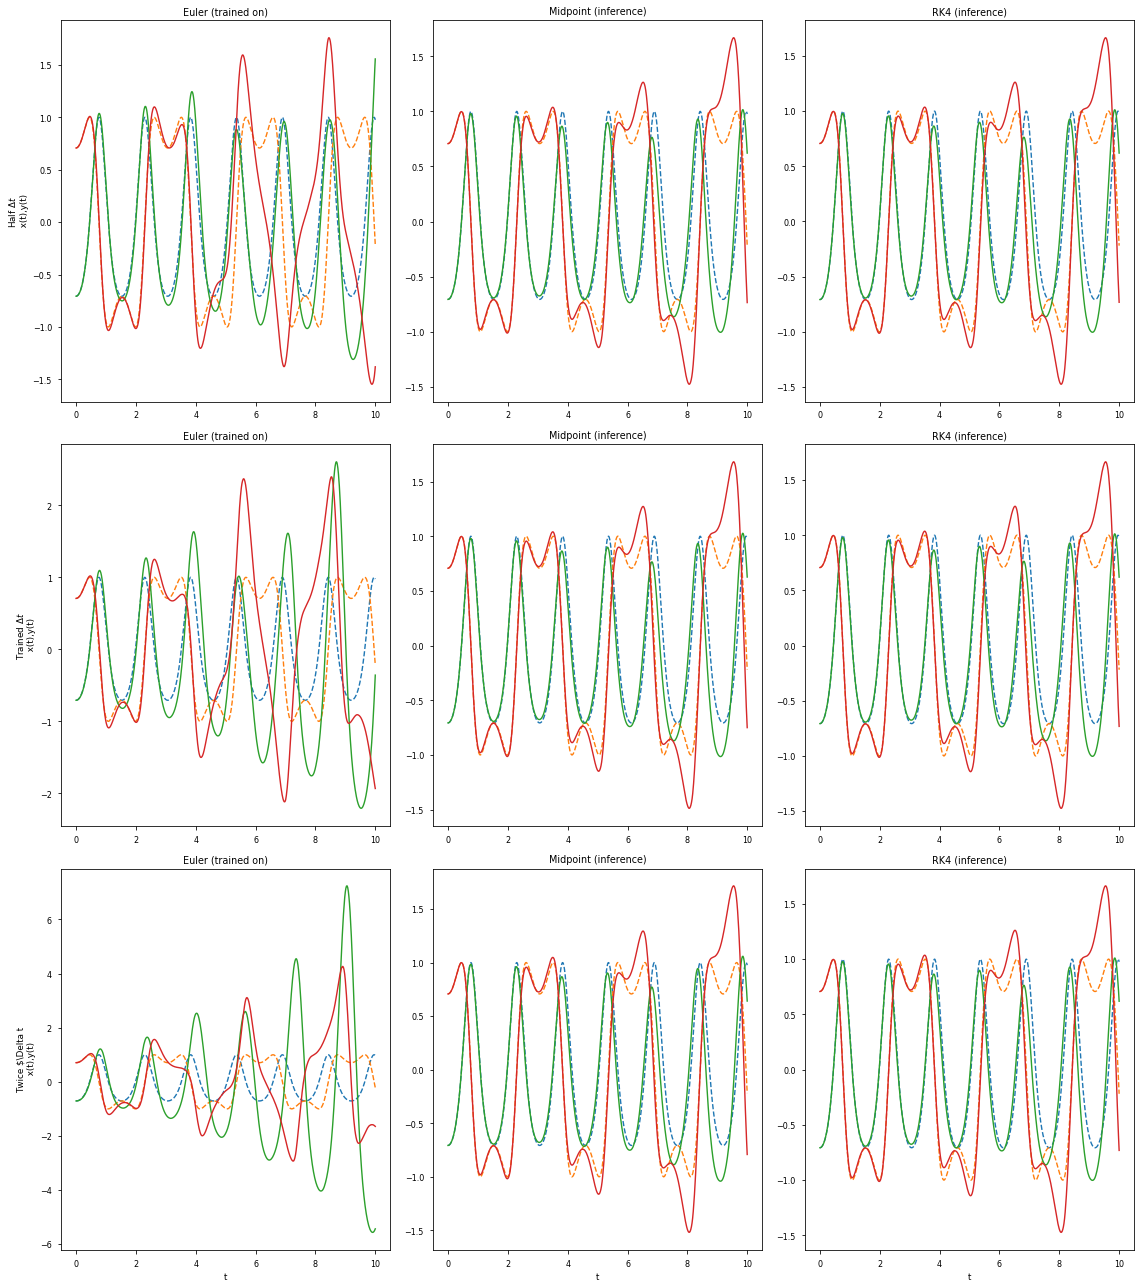

In [0]:
plot_3x3(model_multi, xy_data, xy_ts)
plt.savefig('plots/pend_xy_multiode.png')

# Compare the results

In [0]:
ys = [ [0,1,0,0], [1,0,0,0], [np.sqrt(2),np.sqrt(2),0,0], [np.sqrt(2),-np.sqrt(2),0,0],  ]
for y in ys:
    y = data_to_torch([y],device=device)
    print(FTrue(0,y).detach().numpy())
    print(model_multi(0,y).detach().numpy())
    print(model_neuralode(0,y).detach().numpy())
    print()

[[ 0.    0.    9.81 -0.  ]]
[[ 0.07372961 -0.04148617 -1.42552288 -8.84952317]]
[[ 0.26111053 -0.2223282  -2.27534087 -9.0609527 ]]

[[ 0.  0.  0. -0.]]
[[  0.0982639   -0.30855737 -25.23486519  -2.24264651]]
[[  0.26319153  -0.25931616 -24.60033476  -2.04107228]]

[[  0.     0.    -9.81 -19.62]]
[[  0.15091852  -0.28507536 -37.16552464 -40.92386593]]
[[  0.54601815  -0.54505144 -36.56608475 -35.23111053]]

[[ 0.    0.   -9.81 19.62]]
[[  0.19424951  -0.24537617 -35.91966468  33.04618353]]
[[  0.13691394   0.39780846 -34.77603909  31.10221374]]

